In [1]:
#@title Install
!pip install wfdb > /dev/null 2>&1;

In [2]:
import wfdb
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from scipy.io import loadmat
from keras.utils import to_categorical
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
records = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/all_data.npy', allow_pickle=1)
y = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/y.npy')
labels = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/labels.npy')

labels

array(['Bundle branch block', 'Cardiomyopathy', 'Dysrhythmia',
       'Healthy control', 'Heart failure (NYHA 2)',
       'Heart failure (NYHA 3)', 'Heart failure (NYHA 4)', 'Hypertrophy',
       'Myocardial infarction', 'Myocarditis', 'Palpitation',
       'Stable angina', 'Unstable angina', 'Valvular heart disease',
       'n/a'], dtype='<U22')

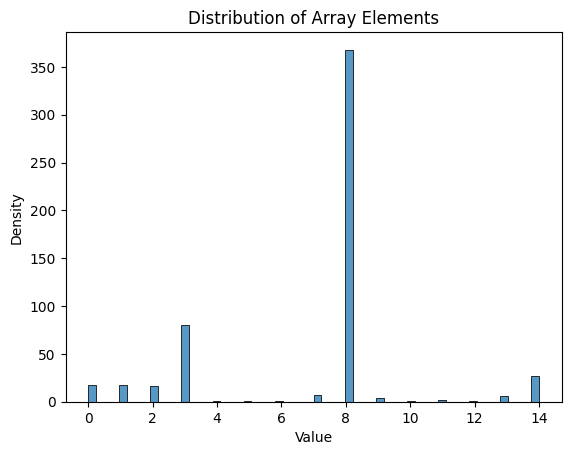

In [5]:
# Plot the KDE
sns.histplot(y)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Array Elements')
plt.show()

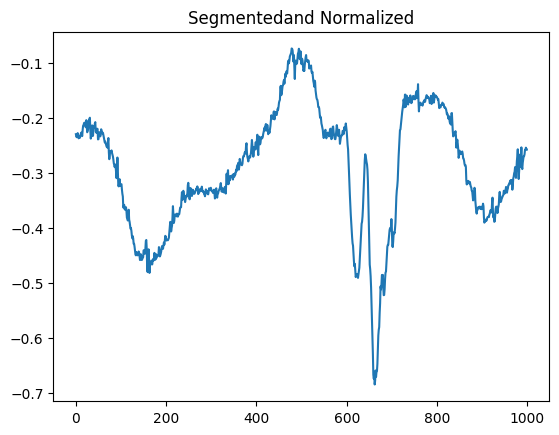

In [6]:
signal = records[0][:1000]
plt.plot(signal)
plt.title('Segmentedand Normalized')
plt.show()

In [7]:
#@title Read the records and headers from physionet.org

# record_names = wfdb.get_record_list('ptbdb')


# records = []
# headers = []
# reasons = []

# for item in record_names:
#     # Read the record
#     patient, record_name = item.split('/')
#     record = wfdb.rdrecord(record_name, pn_dir=f'ptbdb/{patient}', channels=[1],sampto=5000)
#     records.append(record)

#     # Read the header
#     header = wfdb.rdheader(record_name, pn_dir=f'ptbdb/{patient}')
#     headers.append(header)

#     # Extract the Reason for admission feature
#     reason = header.comments[4].split(': ')[1]
#     reasons.append(reason)


In [8]:
len(records[:][:5000])

549

In [9]:

all_label = list(y)
all_data = list(records)


"""Discrete Wavelet Transform"""

import pywt
from statsmodels.robust import mad

#DISCRETE WAVELET TRANSFORM
mf = ['sym8']

hasil = []
for i in range(len(all_data)):
    data = []
    for j in range(len(mf)):
        w=pywt.Wavelet(mf[j])
        ca=[]
        cd=[]
        levels=8
        l = all_data[i]

        for level in range(levels):
            (l, h)=pywt.dwt(l, w)
            ca.append(l)
            cd.append(h)

        l = [0]*len(l)
        l=np.array(l)
        cd.append(l)

        tho = mad(cd[0])
        uthr = tho*np.sqrt(2*np.log(len(all_data[i])))

        new_cd = []
        for h in cd :
            new_cd.append(pywt.threshold(h, value=uthr, mode='soft')) #soft thresolding

        cd_rec = new_cd.copy()
        new_cd.reverse()
        new_signal = pywt.waverec(new_cd, w)
        data.append(new_signal)
        x = np.asarray(data)
        x= x.transpose()
        x = x.flatten()
        hasil.append(x)





In [10]:
all_label = list(y)
d = records[:][:5000]
len(d[0])

38400

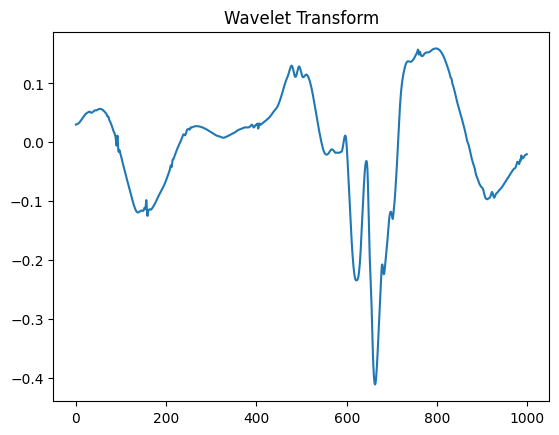

In [11]:
signal = hasil[0][:1000]
plt.plot(signal)
plt.title('Wavelet Transform')
plt.show()

In [12]:


"""Normalize Signal using Normalize Bound"""

from wfdb.processing import normalize_bound

normalisasi = []
for i in range(len(hasil)):
    x = normalize_bound(hasil[i], lb=0, ub=1)
    normalisasi.append(x)

"""Signal Segmentation"""

segment_all_signal = []
segment_all_label = []

step = 512

for i in range(len(normalisasi)):

    temp_signal = normalisasi[i]
    pjg_sinyal = len(temp_signal)
    baca = all_label[i]

    for x in range(0, len(temp_signal), step):

        N = (step+x) - pjg_sinyal
        if (x+step < pjg_sinyal):
            ritme = temp_signal[x:x+step]
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

        elif(N<2600):
            ritme= temp_signal[x:x+step]
            ritme = np.pad(ritme, (0, N), 'constant')
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

for i in range(len(segment_all_label)):
    all_data.append(segment_all_signal[i])
    all_label.append(segment_all_label[i])

sum(float(num) == 8 for num in all_label) #Check Data for every label






80775

In [44]:
import numpy as np
from sklearn.utils import resample

segment_all_signal2 = np.asarray(segment_all_signal)
segment_all_label2 = np.asarray(segment_all_label)

SAMPLES = 1000
RANDOM_STATE = 42

def upsample_class(signals, labels, class_label, n_samples, random_state):
    class_indices = np.where(labels == class_label)[0]
    class_signals = signals[class_indices]

    if len(class_signals) < n_samples:
      upsampled_signals = resample(class_signals, replace=True, n_samples=n_samples, random_state=random_state)
      upsampled_labels = np.full(n_samples, class_label)

    else:
      upsampled_signals = resample(class_signals, replace=False, n_samples=n_samples, random_state=random_state)
      upsampled_labels = np.full(n_samples, class_label)

    return upsampled_signals, upsampled_labels

upsampled_signals = []
upsampled_labels = []

for class_label in np.unique(segment_all_label2):
    signals, labels = upsample_class(segment_all_signal2, segment_all_label2, class_label, SAMPLES, RANDOM_STATE)
    upsampled_signals.append(signals)
    upsampled_labels.append(labels)

upsampled_signals = np.concatenate(upsampled_signals)
upsampled_labels = np.concatenate(upsampled_labels)


In [45]:
from collections import Counter


count_dict = Counter(upsampled_labels)

for value, count in count_dict.items():
    print(f"The value {value} appears {count} times.")

The value 0 appears 1000 times.
The value 1 appears 1000 times.
The value 2 appears 1000 times.
The value 3 appears 1000 times.
The value 4 appears 1000 times.
The value 5 appears 1000 times.
The value 6 appears 1000 times.
The value 7 appears 1000 times.
The value 8 appears 1000 times.
The value 9 appears 1000 times.
The value 10 appears 1000 times.
The value 11 appears 1000 times.
The value 12 appears 1000 times.
The value 13 appears 1000 times.
The value 14 appears 1000 times.


In [46]:

X = np.expand_dims(upsampled_signals, axis=-1)
Y = to_categorical(upsampled_labels)


#Splitting Dataset
x_train, x_test, y_train, y_test =train_test_split(X, Y, test_size=0.2, shuffle=1)

In [47]:
y_train.shape

(12000, 15)

In [48]:
x_train.shape

(12000, 512, 1)

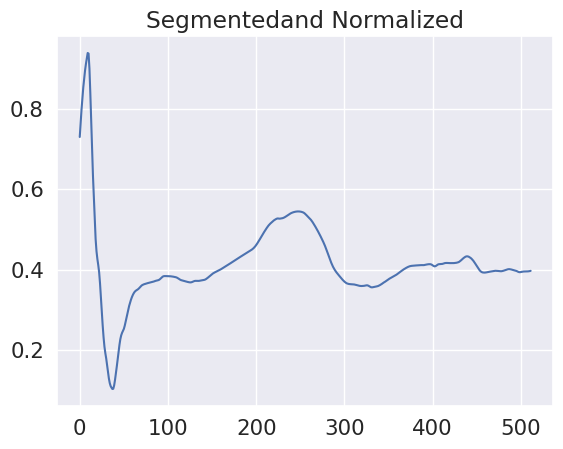

In [49]:

signal = upsampled_signals[0][:1000]
plt.plot(signal)
plt.title('Segmentedand Normalized')
plt.show()

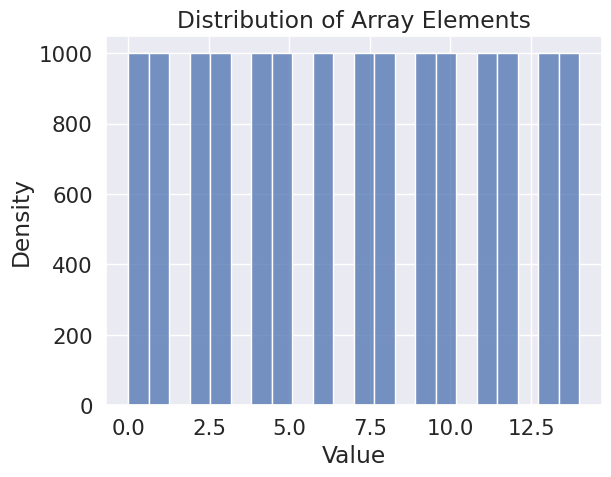

In [50]:

import seaborn as sns
import numpy as np

# Generate an array of random numbers
data = np.random.randn(1000)

# Plot the KDE
sns.histplot(upsampled_labels)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Array Elements')
plt.show()

In [51]:



from keras.layers import Dense, Conv1D, MaxPool1D, Flatten
from keras.models import Sequential
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix as cm
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint



def model_cnn(in_shape):
    model = Sequential()
    model.add(Conv1D(64, 3, input_shape=in_shape, activation='relu'))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPool1D(2, strides=(2)))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(2, strides=(2)))

    model.add(Conv1D(256, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(MaxPool1D(2, strides=(2)))


    model.add(Conv1D(512, 3, activation='relu'))
    model.add(Conv1D(512, 3, activation='relu'))
    model.add(MaxPool1D(2, strides=(2)))

    model.add(Conv1D(512, 3, activation='relu'))
    model.add(Conv1D(512, 3, activation='relu'))
    model.add(MaxPool1D(2, strides=(2)))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])

    return model



In [52]:
model = model_cnn(x_train[0].shape)


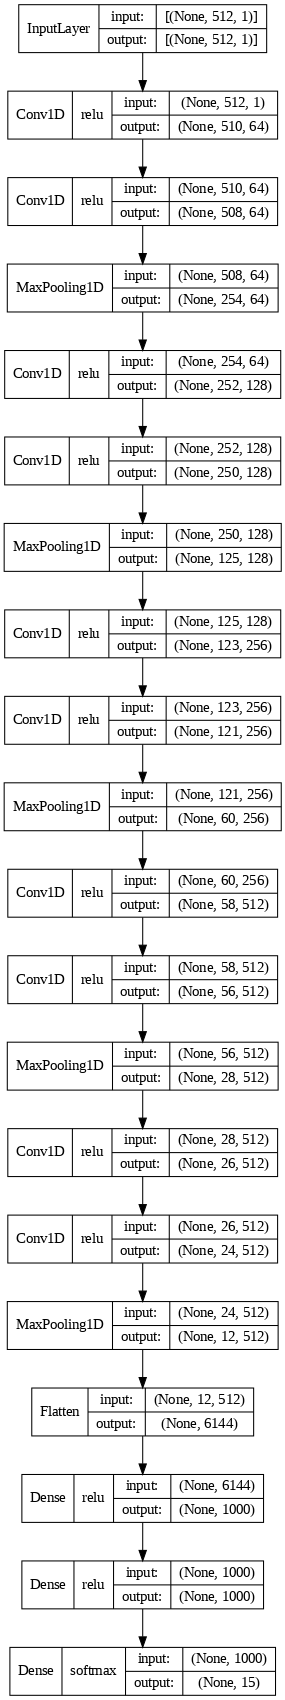

In [53]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=1,
    show_dtype=0,
    show_layer_names=0,
    rankdir="TB",
    expand_nested=1,
    dpi=75,
    show_layer_activations=1,
    show_trainable=0,
)

In [54]:
mc = ModelCheckpoint('best', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
h = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=16,
              epochs=10,
              callbacks=[mc, es])

Epoch 1/10
750/750 [==============================] - 20s 20ms/step - loss: 2.0830 - acc: 0.2876 - val_loss: 1.7191 - val_acc: 0.3863
Epoch 2/10
750/750 [==============================] - 13s 18ms/step - loss: 1.4725 - acc: 0.4939 - val_loss: 1.2545 - val_acc: 0.5683
Epoch 3/10
750/750 [==============================] - 14s 18ms/step - loss: 1.1685 - acc: 0.5873 - val_loss: 1.1134 - val_acc: 0.6210
Epoch 4/10
750/750 [==============================] - 14s 18ms/step - loss: 0.9555 - acc: 0.6610 - val_loss: 0.9366 - val_acc: 0.6677
Epoch 5/10
750/750 [==============================] - 14s 18ms/step - loss: 0.8253 - acc: 0.7079 - val_loss: 0.8683 - val_acc: 0.6950
Epoch 6/10
750/750 [==============================] - 14s 19ms/step - loss: 0.7183 - acc: 0.7435 - val_loss: 0.8416 - val_acc: 0.7197
Epoch 7/10
750/750 [==============================] - 15s 20ms/step - loss: 0.6273 - acc: 0.7770 - val_loss: 0.7842 - val_acc: 0.7433
Epoch 8/10
750/750 [==============================] - 11s 14ms

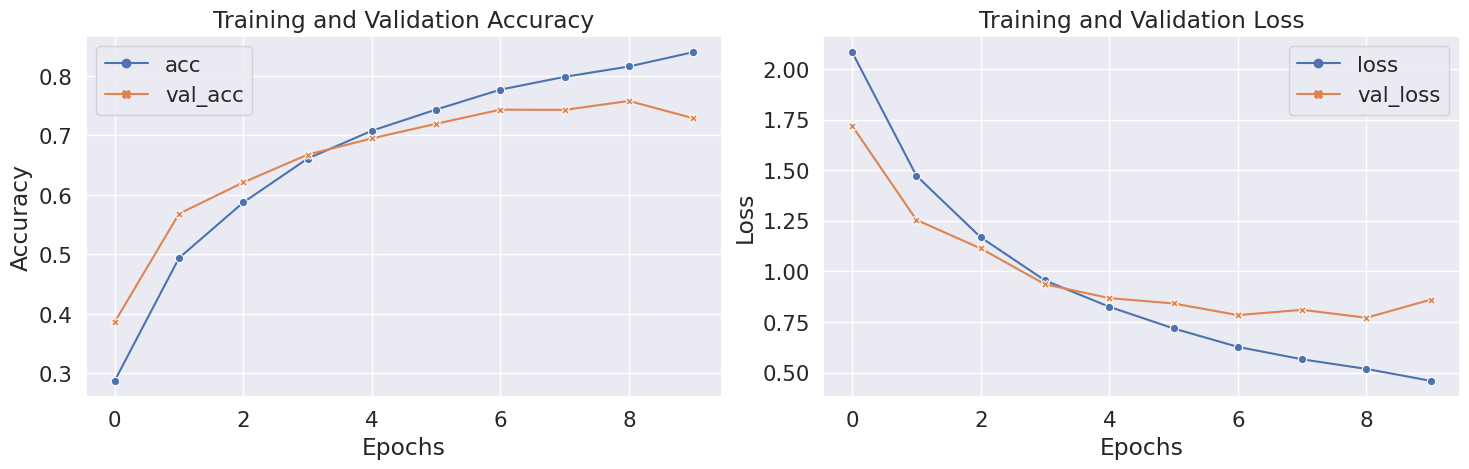

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(h.history)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Accuracy
sns.lineplot(ax=axes[0], data=history_df[['acc', 'val_acc']], markers=True, dashes=False)
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')

# Plot Training and Validation Loss
sns.lineplot(ax=axes[1], data=history_df[['loss', 'val_loss']], markers=True, dashes=False)
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

# Adjust layout
plt.tight_layout()
plt.show()

In [56]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

94/94 [==============================] - 1s 9ms/step


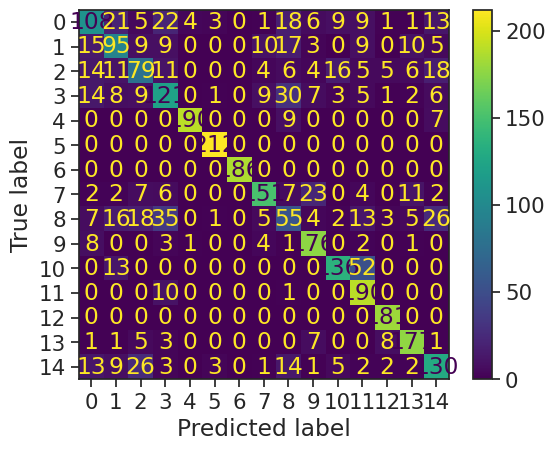

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Evaluate the model on the test data and obtain predicted labels
# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [58]:
list(np.unique(y))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [59]:
from sklearn.metrics import classification_report


report = classification_report(y_true_classes, y_pred_classes)

print(report)

              precision    recall  f1-score   support

           0       0.59      0.49      0.54       221
           1       0.54      0.52      0.53       182
           2       0.50      0.44      0.47       179
           3       0.54      0.56      0.55       216
           4       0.97      0.92      0.95       206
           5       0.96      1.00      0.98       212
           6       1.00      1.00      1.00       186
           7       0.82      0.70      0.75       215
           8       0.35      0.29      0.32       190
           9       0.76      0.90      0.82       196
          10       0.80      0.68      0.73       201
          11       0.65      0.95      0.77       201
          12       0.90      1.00      0.95       181
          13       0.82      0.87      0.85       203
          14       0.62      0.62      0.62       211

    accuracy                           0.73      3000
   macro avg       0.72      0.73      0.72      3000
weighted avg       0.72   

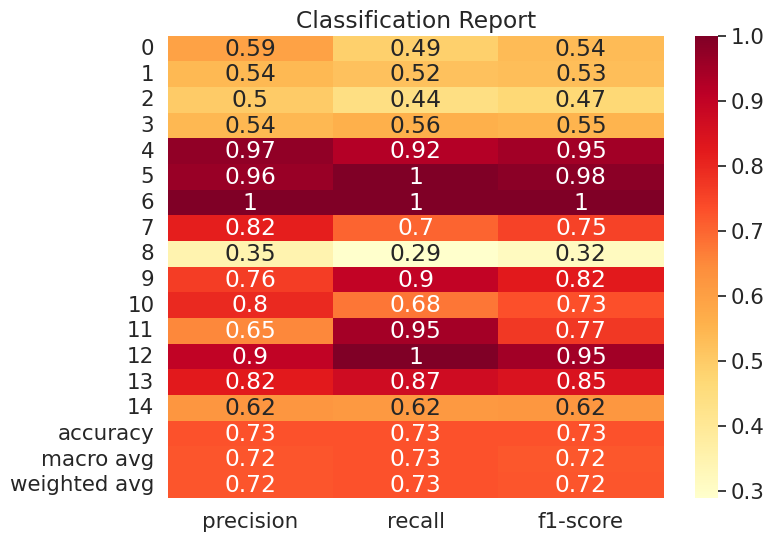

In [60]:
# Plotting the classification report
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(classification_report(y_true_classes, y_pred_classes, output_dict=True)).iloc[:-1, :].T, annot=True, cmap="YlOrRd")
plt.title('Classification Report')
plt.show()